## Prepare data from Synthetic Word Dataset: https://www.robots.ox.ac.uk/~vgg/data/text/#sec-synth
- Upload .zip file to google drive and extract them

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp gdrive/MyDrive/ComputerVision/TextRecognition/data.zip .

In [3]:
from zipfile import ZipFile

In [4]:
with ZipFile('data.zip', 'r') as zip:
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!


## Preprocess data
- explore data
- encode label data

In [5]:
import string
import os
import glob
import fnmatch
import numpy as np
import matplotlib.pyplot as plt

import cv2
from keras.preprocessing.sequence import pad_sequences

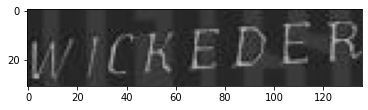

In [6]:
image = cv2.imread('/content/data/2236/6/100_WICKEDER_86476.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [7]:
char_list = string.ascii_letters + string.digits

In [8]:
def encode_label(text):
    encoded_text = []
    for index, char in enumerate(text):
        encoded_text.append(char_list.index(char))
        
    return encoded_text

In [9]:
# Reading data and encode the label
path = 'data'

train_img = []
train_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

max_label_len = 0
i = 1

for root, dirnames, filenames in os.walk(path):
    for f_name in fnmatch.filter(filenames, '*.jpg'):
        img = cv2.cvtColor(cv2.imread(os.path.join(root, f_name)), cv2.COLOR_BGR2GRAY)   

        w, h = img.shape
        if h > 128 or w > 32:
            continue
        if w < 32:
            add_zeros = np.ones((32-w, h))*255
            img = np.concatenate((img, add_zeros))

        if h < 128:
            add_zeros = np.ones((32, 128-h))*255
            img = np.concatenate((img, add_zeros), axis=1)
        img = np.expand_dims(img , axis = 2)
        
        img = img/255.
        
        txt = f_name.split('_')[1]
        
        if len(txt) > max_label_len:
            max_label_len = len(txt)
            
        if i % 10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_label(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            train_img.append(img)
            train_txt.append(encode_label(txt)) 

        i+=1

In [10]:
# Padding data
train_padded_txt = pad_sequences(train_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [11]:
len(train_padded_txt), len(valid_padded_txt)

(147681, 16408)

## Implement the network architecture of CRNN: https://arxiv.org/pdf/1507.05717.pdf

In [12]:
import tensorflow as tf
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [13]:
inputs = Input(shape=(32,128,1))

conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)
act_model = Model(inputs, outputs)

In [14]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [15]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [outputs, labels, input_length, label_length]
)
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [17]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(
    filepath=filepath, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='auto'
)

callbacks_list = [checkpoint]

In [19]:
train_img = np.array(train_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [20]:
batch_size = 256
epochs = 10

history = model.fit(
    x=[train_img, train_padded_txt, train_input_length, train_label_length], 
    y=np.zeros(len(train_img)), 
    batch_size=batch_size, epochs = epochs, 
    validation_data = (
        [valid_img, valid_padded_txt, valid_input_length, valid_label_length], 
        [np.zeros(len(valid_img))]
    ), 
    verbose = 1, callbacks = callbacks_list
)

Epoch 1/10
577/577 [==============================] - ETA: 0s - loss: 26.7530
Epoch 00001: val_loss improved from inf to 26.44957, saving model to best_model.hdf5
577/577 [==============================] - 370s 596ms/step - loss: 26.7530 - val_loss: 26.4496
Epoch 2/10
577/577 [==============================] - ETA: 0s - loss: 12.6779
Epoch 00002: val_loss improved from 26.44957 to 5.85882, saving model to best_model.hdf5
577/577 [==============================] - 330s 571ms/step - loss: 12.6779 - val_loss: 5.8588
Epoch 3/10
577/577 [==============================] - ETA: 0s - loss: 4.4993
Epoch 00003: val_loss improved from 5.85882 to 3.97759, saving model to best_model.hdf5
577/577 [==============================] - 330s 573ms/step - loss: 4.4993 - val_loss: 3.9776
Epoch 4/10
577/577 [==============================] - ETA: 0s - loss: 3.4285
Epoch 00004: val_loss improved from 3.97759 to 3.35961, saving model to best_model.hdf5
577/577 [==============================] - 329s 571ms/step

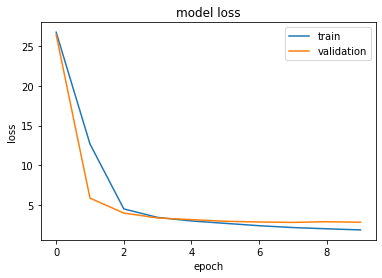

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Prediction

In [41]:
act_model.load_weights('best_model.hdf5')
prediction = act_model.predict(valid_img[:20])

out = K.get_value(
    K.ctc_decode(
        prediction, 
        input_length = np.ones(prediction.shape[0]) * prediction.shape[1],
        greedy = True)[0][0]
)

i = 0
for x in out:
    print("actual text: ", valid_orig_txt[i])
    print("predicted text: ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

actual text:  guilds
predicted text: guilds

actual text:  Spenders
predicted text: Spenders

actual text:  chairwoman
predicted text: CHARVONUN

actual text:  ipad
predicted text: ipad

actual text:  Creeps
predicted text: Creeps

actual text:  SWITCHABLE
predicted text: SWITCHABLE

actual text:  Abolitionists
predicted text: Aboktionists

actual text:  Straight
predicted text: Straight

actual text:  Goes
predicted text: Goes

actual text:  inchon
predicted text: inchon

actual text:  Sophistic
predicted text: Sophistic

actual text:  WAGED
predicted text: WAGED

actual text:  Sanely
predicted text: Sanely

actual text:  MONA
predicted text: MONA

actual text:  Discomfiting
predicted text: Discomfiting

actual text:  separate
predicted text: separate

actual text:  SULK
predicted text: SHLK

actual text:  Unwisely
predicted text: Unwisely

actual text:  Licorice
predicted text: Licorice

actual text:  Nubs
predicted text: Nubs

